# Representation exploration of chemical structures.  
  
In this notebook we take a look at the pre-trained representations of MolE and ECFP4 when it comes to determining molecular similarity from 100K molecules from PubChem that were not used during pre-training. 

In [1]:
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Low dimensional embeddings
import umap

# Correlations and distances
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.spatial.distance import pdist, squareform, cdist


# Rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

from rdkit.Chem import DataStructs


/home/roberto_olayo/miniconda3/envs/mole_test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare directories

In [2]:
RAW_DATA_DIR = "../raw_data"

INPUT_DIR = "../data/01.prepare_training_data/"

OUTPUT_DIR = "../data/07.pubchem_exploration"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Read data

In [3]:
# Gather representations
mole_pubchem = pd.concat([pd.read_csv(os.path.join(INPUT_DIR, f"pubchem_mole_representation_p{n}.tsv.gz"), 
                                                                                                        sep='\t', index_col=0) for n in [1,2,3,4]])

ecfp4_pubchem = pd.read_csv(os.path.join(INPUT_DIR, "pubchem_ecfp4_representation.tsv.gz"), sep='\t', index_col="chem_id")

In [4]:
# Gather metadata
pchem_df = pd.read_csv(os.path.join(RAW_DATA_DIR, "pubchem_random", "pubchem_100k_selected_smiles.tsv.gz"), sep='\t')
pchem_meta = pchem_df.copy()


# Calculate Molecular weight
pchem_meta["MolWt"] = pchem_meta["smiles"].apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))

# Robust range of molecular weight for easier viz
upper_limit = pchem_meta["MolWt"].quantile(0.75)
lower_limit = pchem_meta["MolWt"].quantile(0.25)

pchem_meta["MolWt_rob"] = pchem_meta["MolWt"].clip(upper=upper_limit, lower=lower_limit)
pchem_meta = pchem_meta[["chem_id", "MolWt", "MolWt_rob"]].set_index("chem_id")
pchem_meta.head()

,MolWt,MolWt_rob
chem_id,,
chem_0,366.091725,366.091725
chem_1,277.098190,277.098190
chem_2,461.107913,419.185349
chem_3,379.100892,379.100892
chem_4,344.936388,344.936388


## UMAP embeddings

### ECFP4 embedding

In [5]:
# Using a jaccard distance since ECFP4 are binary vectors
reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=10, min_dist=0.4, metric="jaccard")

embedding = reducer.fit_transform(ecfp4_pubchem.values)

# Save embedding as UMAP
fps_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = ecfp4_pubchem.index)

# Add mol weight information
fps_umap = fps_umap.join(pchem_meta)

/home/roberto_olayo/miniconda3/envs/mole_test/lib/python3.8/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/roberto_olayo/miniconda3/envs/mole_test/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/roberto_olayo/miniconda3/envs/mole_test/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: xlabel='umap1', ylabel='umap2'>

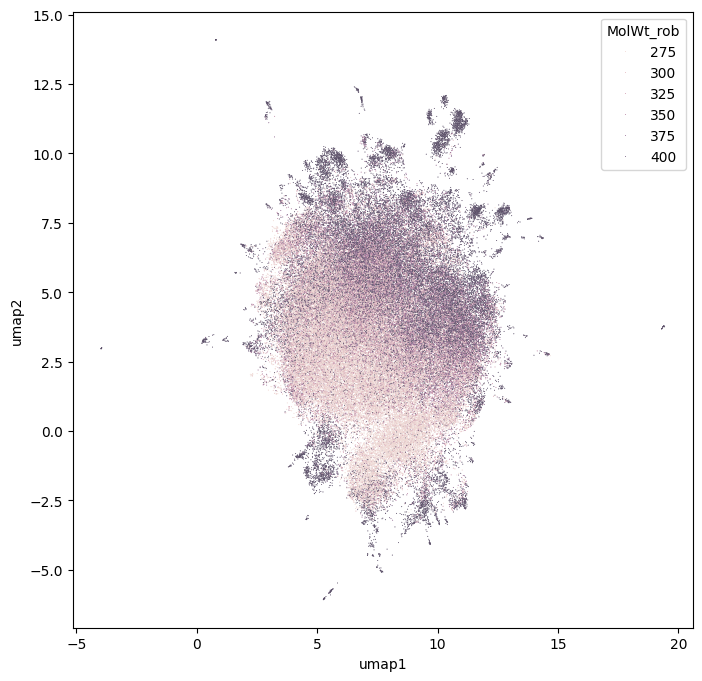

In [6]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=fps_umap, x="umap1", y="umap2", s=0.5, hue="MolWt_rob")


### MolE embedding

In [7]:
# Here we use the cosine distance. All other hyperparameters are the same
reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=10, min_dist=0.4, metric="cosine")

embedding = reducer.fit_transform(mole_pubchem.values)

mole_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = mole_pubchem.index)
                          
# Add mol weight information
mole_umap = mole_umap.join(pchem_meta)

/home/roberto_olayo/miniconda3/envs/mole_test/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='umap1', ylabel='umap2'>

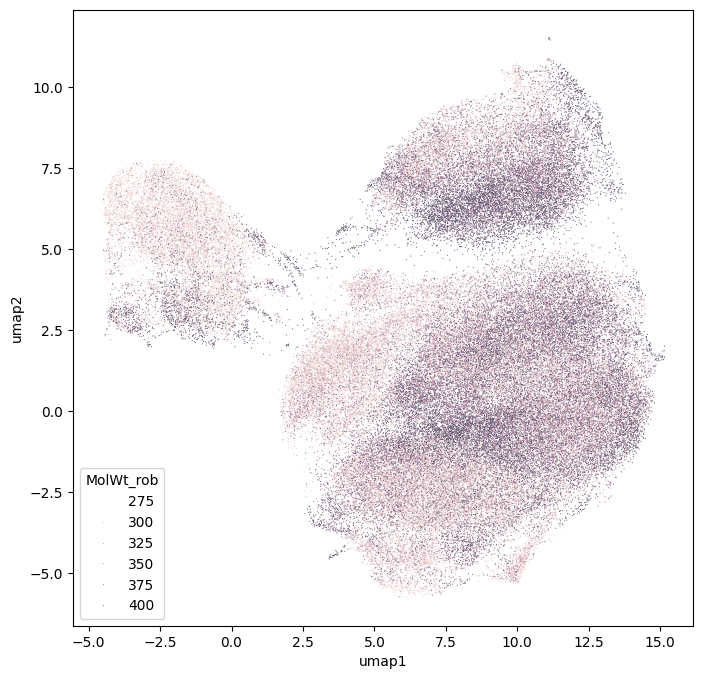

In [8]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=mole_umap, x="umap1", y="umap2", s=0.5, hue="MolWt_rob")


## Highlight similar molecules

In [9]:
# Rdit draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

Draw molecular structures to highlight

In [10]:
def generate_molObj(cid, df):

    # Get the corresponding smile
    smilestr = df.loc[df["chem_id"] == cid, "smiles"].values[0]

    # Generate the MolObj
    mol = Chem.MolFromSmiles(smilestr)
    mol._Name = cid

    return mol

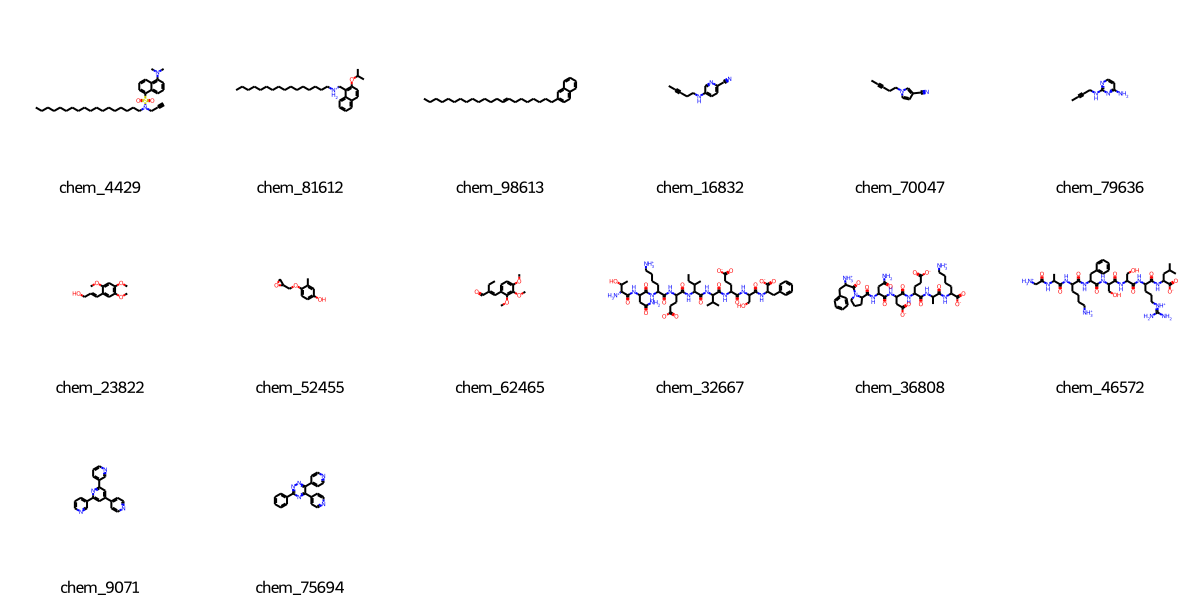

In [11]:
# Molecules to highlight
highlight_molecules = [f"chem_{n}" for n in [4429, 81612, 98613, # Naphthalene with a long carbon chain
                                             16832, 70047, 79636, # Nitrogen heterocycles with alkyne and nitrile group
                                             23822, 52455, 62465, # Benzene surrounded by ether bonds
                                             32667, 36808, 46572, # Amino acid chains
                                             9071, 75694 # Pyridines bound to central nitrogen heterocycle
                                             ]]


# Mol objects list
highlight_molobj = [generate_molObj(cid=i, df=pchem_df) for i in highlight_molecules]

# Draw pictures
img = Draw.MolsToGridImage(highlight_molobj, molsPerRow=6, legends=[m._Name for m in highlight_molobj])
img

Highlight structures in UMAP

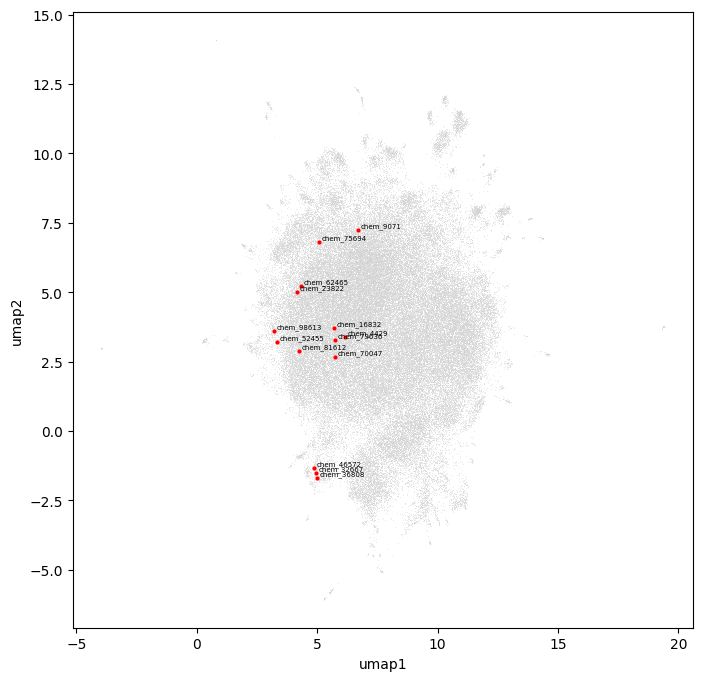

In [12]:
#ECFP4 highlight
plt.figure(figsize=(8,8))
sns.scatterplot(data=fps_umap, x="umap1", y="umap2", s=0.5, color="#C5C5C5", alpha=0.5)
sns.scatterplot(data=fps_umap.loc[highlight_molecules], x="umap1", y="umap2", s=12, color="red")


for cid in highlight_molecules:
    plt.text(x=fps_umap.umap1[cid] + 0.1,
             y=fps_umap.umap2[cid] + 0.1,
             s=cid,
             fontdict={"size":5})


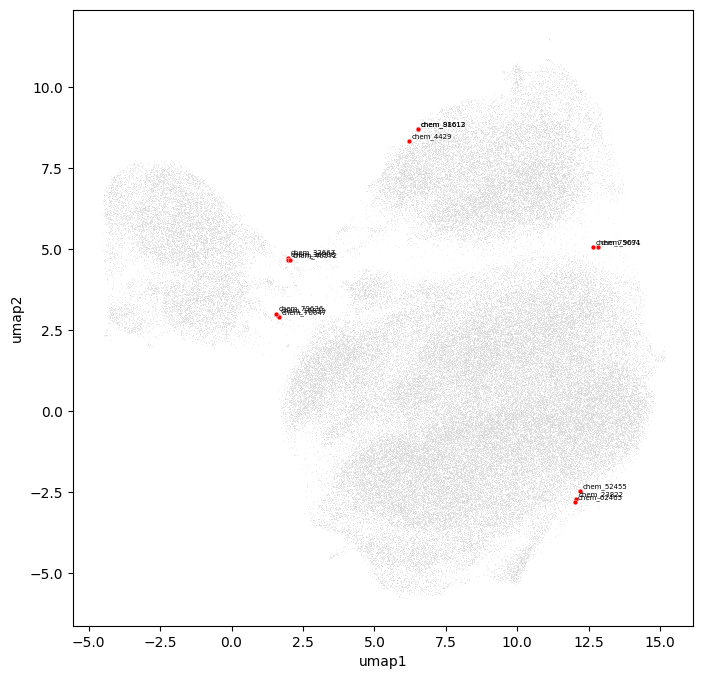

In [13]:
#MolE highlight
plt.figure(figsize=(8,8))
sns.scatterplot(data=mole_umap, x="umap1", y="umap2", s=0.5, color="#C5C5C5", alpha=0.5)
sns.scatterplot(data=mole_umap.loc[highlight_molecules], x="umap1", y="umap2", s=12, color="red")


for cid in highlight_molecules:
    plt.text(x=mole_umap.umap1[cid] + 0.1,
             y=mole_umap.umap2[cid] + 0.1,
             s=cid,
             fontdict={"size":5})

## Ranking similar molecules

Generate fingerprints for Tanimoto similarities

In [14]:
import pickle

In [15]:
with open(os.path.join(OUTPUT_DIR, "fps_dictionary.pkl"), "rb") as file:
    fps_dictionary = pickle.load(file)
    

Specify query molecules

In [16]:
query_molecules = [f"chem_{n}" for n in [100003, # Ractopamine
                                         100000, # PubChem ID: 12277389
                                         28465, # PubChem ID: 98701517
                                         100001, 100002 # Additional queries
                                         ]]

In [17]:
# A function to gather the pairwise distances for a list of given query IDs
def query_distances(q_chems, chem_df, distance_metric):

    # Gather the representation for the query
    query_df = chem_df.loc[q_chems]

    # Gather the representation for the remaining compounds
    reference_df = chem_df.drop(index=q_chems)

    # Calculate distances
    cdist_df = pd.DataFrame(cdist(query_df, reference_df, metric=distance_metric), 
                            index = q_chems, columns=reference_df.index)

    return cdist_df

# A function that determines the tanimoto similarity for a given query
def query_tanimoto(qchem, fps_dict):

    # Gather the fingerprint
    query_object = fps_dict[qchem]

    # Compare to all other fingerprints
    result_list = [[qchem, cid, DataStructs.TanimotoSimilarity(query_object, 
                                                              fps_obj)] for cid, fps_obj in fps_dict.items()]
    
    # Aggregate all results
    result_df = pd.DataFrame(result_list, columns=["query", "chem_id", "tanimoto_sim"])

    return result_df

In [18]:
#Query cosine and jaccard distances
mole_query = query_distances(query_molecules, mole_pubchem, "cosine")
ecfp4_query = query_distances(query_molecules, ecfp4_pubchem, "jaccard")

In [21]:
# Query Tanimoto
tanimoto_racto = query_tanimoto("chem_100003", fps_dictionary) 
tanimoto_long = query_tanimoto("chem_100000", fps_dictionary) 
tanimoto_sulfur = query_tanimoto("chem_28465", fps_dictionary)

# Join all results. Ignore self queries
tanimoto_query = pd.concat([tanimoto_racto, tanimoto_long, tanimoto_sulfur])
tanimoto_query = tanimoto_query.loc[~tanimoto_query["chem_id"].isin(query_molecules)]

# Since the metric is a similarity we can subtract 1 and get the corresponding distance
tanimoto_query["tanimoto_dist"] = 1 - tanimoto_query["tanimoto_sim"]

# Pivot wider
tanimoto_query = tanimoto_query.pivot_table(index="query", columns="chem_id", values="tanimoto_dist")


### Rank Comparison

In [22]:
def rank_comparison(qchem, jaccard_df=ecfp4_query, cosine_df=mole_query, tanimoto_df=tanimoto_query):

    # Gather ranks for jaccard
    jaccard_rank = pd.DataFrame(jaccard_df.loc[qchem].rank(method="first", ascending=True)).rename(columns={qchem: "jaccard_rank"})

    # Gather ranks for cosine
    cosine_rank = pd.DataFrame(cosine_df.loc[qchem].rank(method="first", ascending=True)).rename(columns={qchem: "cosine_rank"})

    # Gather ranks for Tanimoto. Since Tanimoto is a similarity, we rank in descending order
    tanimoto_rank = pd.DataFrame(tanimoto_df.loc[qchem].rank(method="first", ascending=True)).rename(columns={qchem: "tanimoto_rank"})

    # Finally, gather the distances
    jaccard_dist = jaccard_df.loc[qchem].to_frame().rename(columns={qchem: "jaccard_dist"})
    jaccard_dist["jaccard_log2"] = np.log2(jaccard_dist.jaccard_dist)

    cosine_dist = cosine_df.loc[qchem].to_frame().rename(columns={qchem: "cosine_dist"})
    cosine_dist["cosine_log2"] = np.log2(cosine_dist.cosine_dist)

    tanimoto_dist = tanimoto_df.loc[qchem].to_frame().rename(columns={qchem: "tanimoto_dist"})
    tanimoto_dist["tanimoto_dist_log2"] = np.log2(tanimoto_dist.tanimoto_dist)

    # Join results
    rank_comparison_df = jaccard_rank.join(cosine_rank).join(tanimoto_rank).join(jaccard_dist).join(cosine_dist).join(tanimoto_dist)

    return rank_comparison_df



In [23]:
ranking_100003 = rank_comparison("chem_100003")
ranking_100000 = rank_comparison("chem_100000")
ranking_28465 = rank_comparison("chem_28465")

Gather ranks of interest

In [24]:
def gather_most_similar_molecules(rank_df, ranks_to_recover = [1,2,3,4]):

    # Gather the ranks of interest for each ranking strategy
    ranks_interest = rank_df.loc[(rank_df.jaccard_rank.isin(ranks_to_recover)) |
                   (rank_df.cosine_rank.isin(ranks_to_recover)) |
                   ((rank_df.tanimoto_rank.isin(ranks_to_recover)))].reset_index()
    

    # Create a string that summarizes the ranking
    ranks_interest["legend"] = ranks_interest.apply(lambda x: f"{x.chem_id}\nMolE rank: {x.cosine_rank}\nECFP4 rank: {x.jaccard_rank}\n Tanimoto rank: {x.tanimoto_rank}", axis=1)
    
    return ranks_interest

In [25]:
ranking_100003_top4 = gather_most_similar_molecules(ranking_100003)
ranking_100000_top4 = gather_most_similar_molecules(ranking_100000)
ranking_28465_top4 = gather_most_similar_molecules(ranking_28465)

In [26]:
from collections import defaultdict

In [27]:
def ranked_molobj(qchem, rank_df, ranks_to_recover = [0,1,2,3,4], smile_df=pchem_df):

    # Iterate over ranking and gather the corresponding 
    ranked_molobjs = defaultdict(list)
    for r in ranks_to_recover:
        for d in ["jaccard_rank", "cosine_rank", "tanimoto_rank"]:

            if r == 0:
                cid = qchem
                legend_str = "Query Molecule"

            else:
                cid = rank_df.loc[rank_df[d] == r, "chem_id"].values[0]
                legend_str = rank_df.loc[rank_df[d] == r, "legend"].values[0]

            molobj = Chem.MolFromSmiles(smile_df.loc[smile_df["chem_id"]==cid, "smiles"].values[0])
            molobj._Name = legend_str
            ranked_molobjs[d].append(molobj)
    
    complete_list = ranked_molobjs["cosine_rank"] + ranked_molobjs["jaccard_rank"] + ranked_molobjs["tanimoto_rank"]

    return complete_list

Draw the highlighted molecules

In [28]:
ranked_molobj_100003 = ranked_molobj("chem_100003", ranking_100003_top4)
ranked_molobj_100000 = ranked_molobj("chem_100000", ranking_100000_top4)
ranked_molobj_28465 = ranked_molobj("chem_28465", ranking_28465_top4)

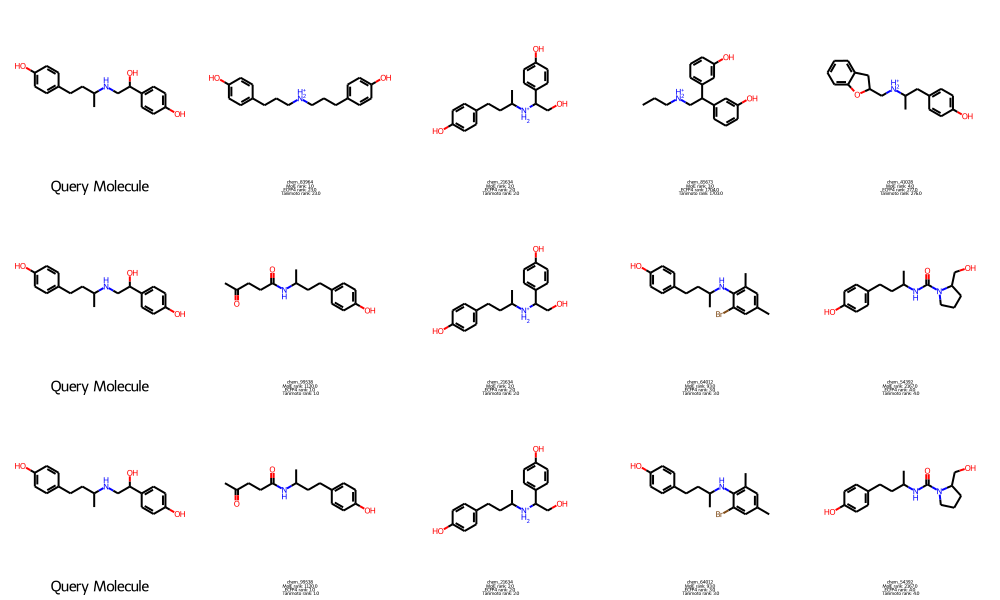

In [29]:
img = Draw.MolsToGridImage(ranked_molobj_100003, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_100003], subImgSize=(200,200), returnPNG=False)
img

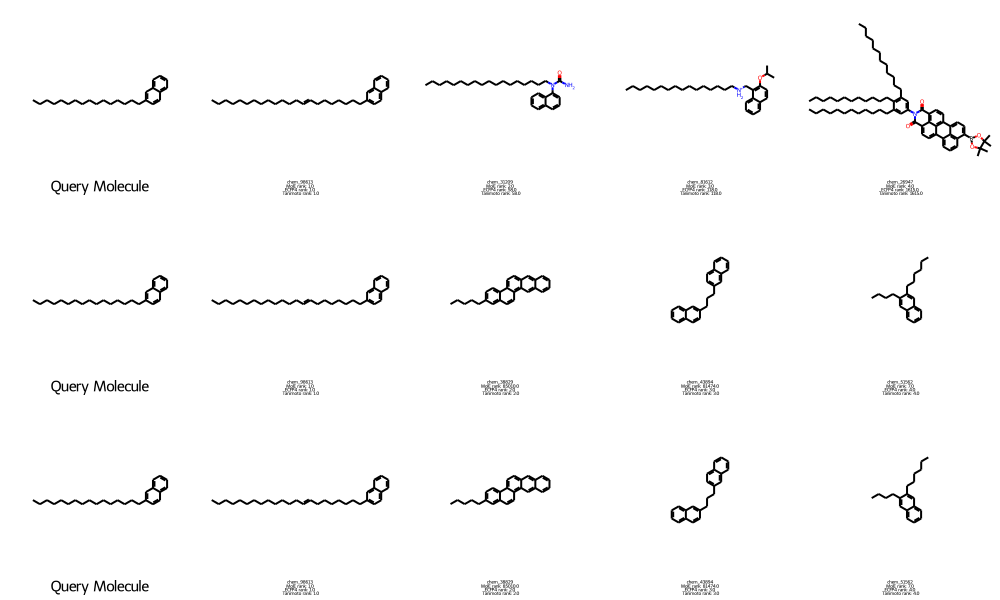

In [30]:
img = Draw.MolsToGridImage(ranked_molobj_100000, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_100000], subImgSize=(200,200), returnPNG=False)
img

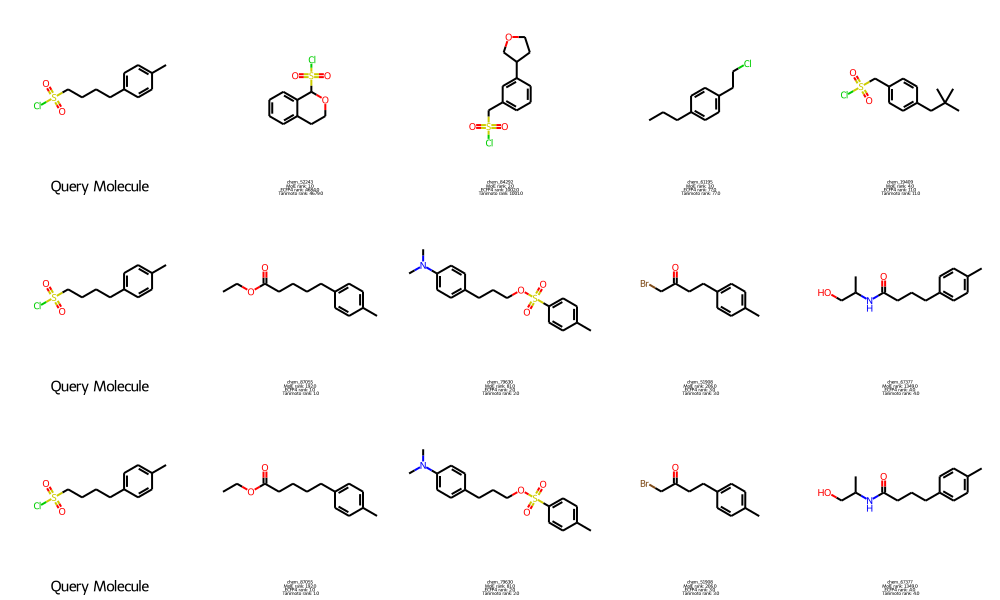

In [31]:
img = Draw.MolsToGridImage(ranked_molobj_28465, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_28465], subImgSize=(200,200), returnPNG=False)
img

In [32]:
img = Draw.MolsToGridImage(ranked_molobj_100003, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_100003], subImgSize=(200,200), useSVG=True)

with open(os.path.join(OUTPUT_DIR, "similar_molecules_chem100003.svg"), 'w') as file:
    file.write(img.data)

img = Draw.MolsToGridImage(ranked_molobj_100000, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_100000], subImgSize=(200,200), useSVG=True)

with open(os.path.join(OUTPUT_DIR, "similar_molecules_chem100000.svg"), 'w') as file:
    file.write(img.data)


img = Draw.MolsToGridImage(ranked_molobj_28465, molsPerRow=5, 
                           legends=[m._Name for m in ranked_molobj_28465], subImgSize=(200,200), useSVG=True)

with open(os.path.join(OUTPUT_DIR, "similar_molecules_chem28465.svg"), 'w') as file:
    file.write(img.data)

## Distance comparison

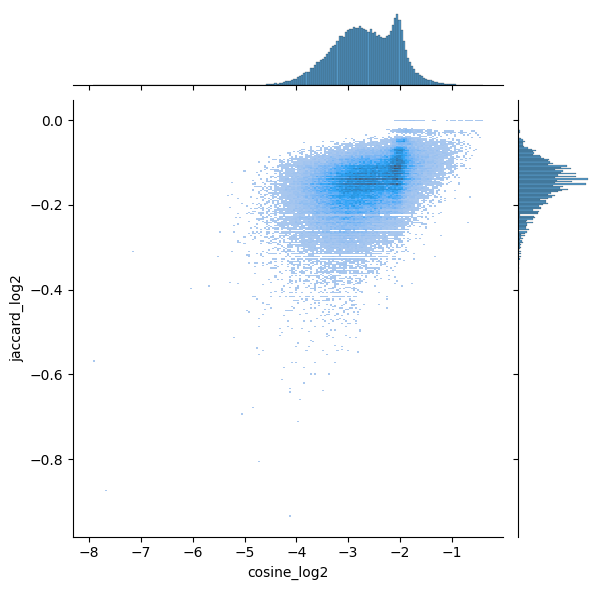

In [33]:
#plt.figure(figsize=(8,8))
sns.jointplot(data=ranking_100003, x="cosine_log2", y="jaccard_log2", kind="hist")

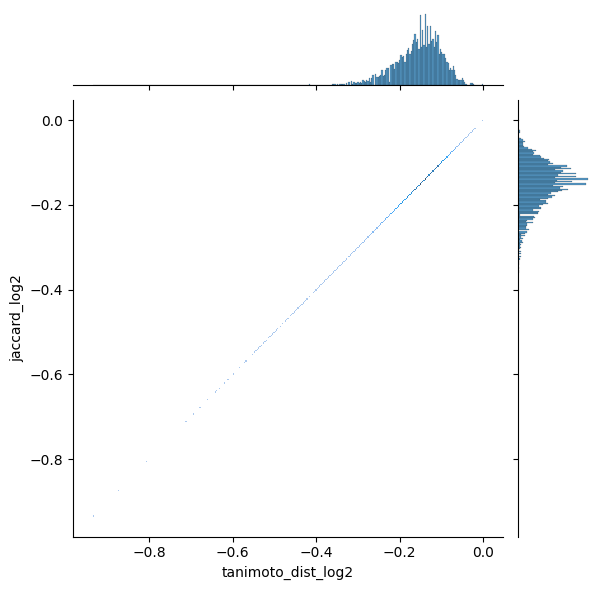

In [34]:
sns.jointplot(data=ranking_100003, x="tanimoto_dist_log2", y="jaccard_log2", kind="hist")

## Write files

In [35]:
ranking_100003.to_csv(os.path.join(OUTPUT_DIR, "ranking_100003.tsv.gz"), sep='\t')
ranking_100000.to_csv(os.path.join(OUTPUT_DIR, "ranking_100000.tsv.gz"), sep='\t')
ranking_28465.to_csv(os.path.join(OUTPUT_DIR, "ranking_28465.tsv.gz"), sep='\t')